### Importo as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dt
import matplotlib.pyplot as plt

### Importo os dados dos setores

In [2]:
# Importo os dados do s&p e transformo em uma lista
all_tickers = list(pd.read_csv('components.csv', index_col=0)['Nasdaq'].dropna())

### Puxo os dados do yahoo

In [4]:
%%time
# Defino qual será a data de início dos dataframes de preços
start_date = '2018-12-01'

# Crio um dicionário que irá conter a série de preços de cada ação
prices = pd.DataFrame()

# Pego apenas a coluna Adjusted Close porque é o que me interessa
errors = []
for s in range(0, len(all_tickers)):
    try:
        prices[all_tickers[s]] = dt.DataReader(all_tickers[s], start=start_date, data_source='yahoo')['Adj Close']
    except:
        errors.append(all_tickers[s])  
        pass

Wall time: 1min 46s


In [26]:
# Pego os dados do ibovespa
ibov = dt.DataReader('^IXIC', start=start_date, data_source='yahoo')['Adj Close']    

### Tratando a base de dados

In [27]:
# Crio uma função que preenche dados vazios
def fill_values(df):
    if isinstance(ibov, pd.Series):
        init = df.first_valid_index()
        end = df.last_valid_index()
        df.loc[init:end]=df.loc[init:end].fillna(method='ffill')
    else:    
        for i in df.columns.values:
            init = df[i].first_valid_index()
            end = df[i].last_valid_index()
            df[i].loc[init:end]=df[i].loc[init:end].fillna(method='ffill')

In [28]:
# Preencho os valores descontinuos de precos
fill_values(prices)
fill_values(ibov) 

In [29]:
trade_dates = prices['2020':].index
deltas = prices.pct_change()

In [30]:
# Inputs
day = 250
percentile = .2
cumm_returns = prices.pct_change(day)

### Rodando o modelo

In [31]:
%%time

wallet_deltas={}
data = pd.DataFrame(columns=['Long', 'Short'])
for d in range(1, len(trade_dates)):

    sorted_returns = cumm_returns.loc[trade_dates[d-1]].dropna().sort_values()
    
    # Seleciona os quintis
    sell = sorted_returns.head(int(percentile*len(sorted_returns)))
    buy = sorted_returns.tail(int(percentile*len(sorted_returns)))
    
    # Momentum weighted
    if any(sell>0) == True:
        sell_weights = (sell.where(sell<0, 0)/sum(sell.where(sell<0, 0))/2 + sell.where(sell>0, 0)/sum(sell.where(sell>0, 0))/2)
    else:
        sell_weights = sell/sum(sell)
        
    if any(buy<0) == True:
        buy_weights = (buy.where(buy<0, 0)/sum(buy.where(buy<0, 0))/2 + buy.where(buy>0, 0)/sum(buy.where(buy>0, 0))/2)
    else:
        buy_weights = buy/sum(buy) 

    buy_returns = deltas.loc[trade_dates[d], buy_weights.index]
    sell_returns = deltas.loc[trade_dates[d], sell_weights.index]

    # Calcula o retorno
    delta = (np.dot(buy_returns, buy_weights) + np.dot(sell_returns, sell_weights)*-1)/2
    data.loc[trade_dates[d], 'Long'] = np.dot(buy_returns, buy_weights)
    data.loc[trade_dates[d], 'Short'] = np.dot(sell_returns, sell_weights)*-1
    wallet_deltas.update({trade_dates[d]:delta})       
    
    
    
cota = pd.Series(wallet_deltas).add(1).cumprod() 

Wall time: 1.37 s


#### Mesmo modelo, porém pesando por equal-weights

In [32]:
%%time
wallet_deltas={}

wallet_deltas={}
for d in range(1, len(trade_dates)):

    sorted_returns = cumm_returns.loc[trade_dates[d-1]].dropna().sort_values()

    sell = sorted_returns.head(int(percentile*len(sorted_returns)))
    buy = sorted_returns.tail(int(percentile*len(sorted_returns)))

    # Equal weighted
    sell_weights = abs(sell/sell)/len(sell)    
    buy_weights = abs(buy/buy)/len(buy)

    buy_returns = deltas.loc[trade_dates[d], buy_weights.index]
    sell_returns = deltas.loc[trade_dates[d], sell_weights.index]

    delta = (np.dot(buy_returns, buy_weights) + np.dot(sell_returns, sell_weights)*-1)/2
    wallet_deltas.update({trade_dates[d]:delta})       
    
    
    
cota2 = pd.Series(wallet_deltas).add(1).cumprod() 

Wall time: 984 ms


### Visualizando

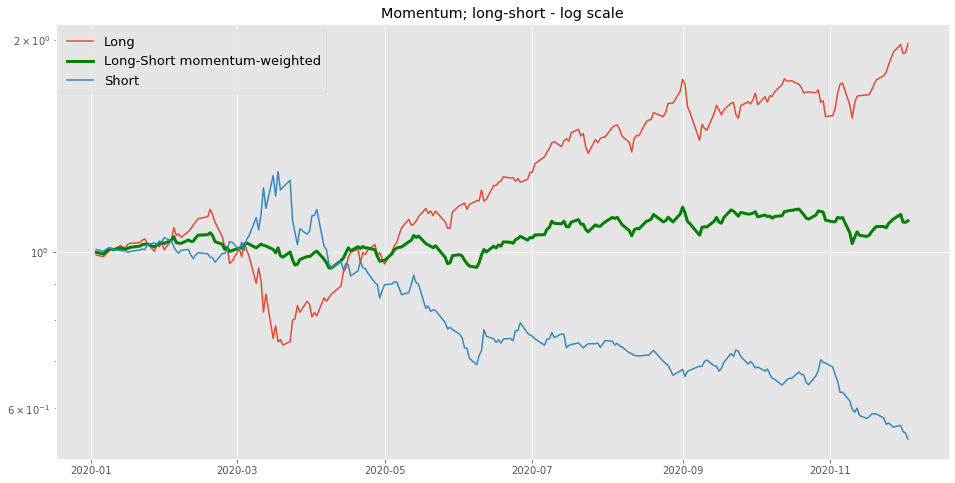

In [33]:
# Retornos das pontas Long e Short

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
plt.style.use('ggplot')
ax.plot(data['Long'].add(1).cumprod(), label='Long')
ax.plot(cota, label='Long-Short momentum-weighted', lw=3, color='green')
ax.plot(data['Short'].add(1).cumprod(), label='Short')
ax.set_yscale('log')
ax.set_title('Momentum; long-short - log scale')
ax.legend(fontsize=13)
#plt.savefig('ls-mom.png')

### Comparação dos portfolios

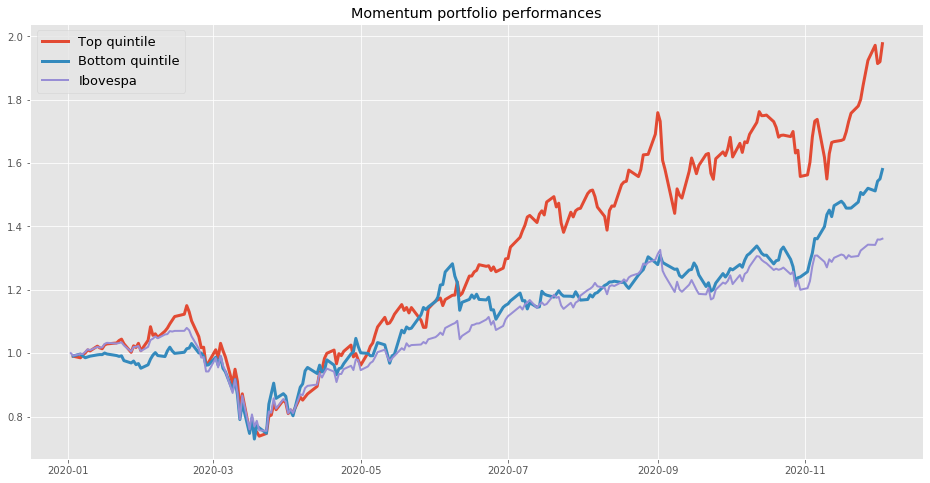

In [34]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
plt.style.use('ggplot')
ax.plot(data['Long'].add(1).cumprod(), label='Top quintile', lw=3)
ax.plot((data['Short']*-1).add(1).cumprod(), label='Bottom quintile', lw=3)
ax.plot(ibov['2020':]/ibov['2020-01-02'], label='Ibovespa', lw=2)
ax.set_title('Momentum portfolio performances')
ax.legend(fontsize=13)
#plt.savefig('two_port.png')

In [35]:
# Diferenca de retorno do long e short
abs((data['Short']*-1).add(1).cumprod().tail(1)-1) - abs(data['Long'].add(1).cumprod().tail(1)-1)

2020-12-03   -0.396995
dtype: object

In [36]:
# Diferenca do long pro ibovespa
abs((ibov['2020':]/ibov['2020':].iloc[0]).tail(1)-1) - abs(data['Long'].add(1).cumprod().tail(1)-1)

Date
2020-12-03   -0.615477
dtype: object

In [37]:
# Volatilidade pra ponta short
(data['Short']*-1).std()*252**0.5

0.40626292389098917

In [38]:
# Volatilidade pra ponta long
(data['Long']*-1).std()*252**0.5

0.4484216374092312

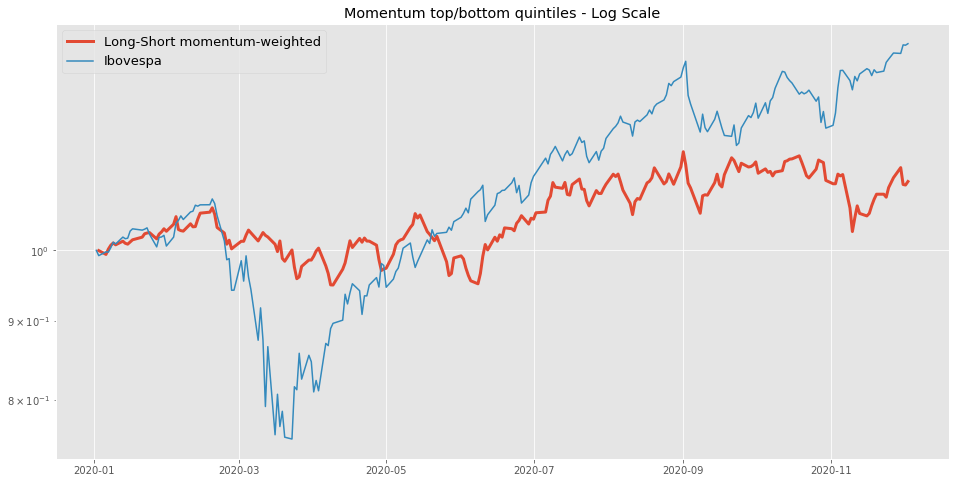

In [39]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
plt.style.use('ggplot')
#ax.plot(cota2, label='Long-Short equal-weighted', lw=3)
ax.plot(cota, label='Long-Short momentum-weighted', lw=3)
ax.plot(ibov['2020':]/ibov['2020-01-02'], label='Ibovespa')
ax.set_yscale('log')
ax.set_title('Momentum top/bottom quintiles - Log Scale')
ax.legend(fontsize=13)

### Stats

In [40]:
mom_vol = cota.pct_change().std()*252**0.5
mom_sharpe = cota.pct_change().mean()/mom_vol
mom_cagr = (cota.tail(1)-1).item()
ew_vol = cota2.pct_change().std()*252**0.5
ew_sharpe = cota2.pct_change().mean()/ew_vol
ew_cagr = (cota2.tail(1)-1).item()
ibov_vol = ibov['2020':].pct_change().std()*252**0.5
ibov_sharpe = ibov['2020':].pct_change().mean()/ibov_vol
ibov_cagr = ((ibov['2020':]/ibov['2020':].iloc[0]).tail(1)-1).item()

In [41]:
print('Momentum-weighted Long-Short portfolio: \n \
Return: {:.2%} \n \
Volatility: {:.2%} \n \
Sharpe: {:.4f}'.format(mom_cagr, mom_vol, mom_sharpe))

Momentum-weighted Long-Short portfolio: 
 Return: 10.82% 
 Volatility: 20.17% 
 Sharpe: 0.0026


In [42]:
print('Momentum Equal-weighted Long-Short portfolio: \n \
Return: {:.2%} \n \
Volatility: {:.2%} \n \
Sharpe: {:.4f}'.format(ew_cagr, ew_vol, ew_sharpe))

Momentum Equal-weighted Long-Short portfolio: 
 Return: 6.18% 
 Volatility: 16.72% 
 Sharpe: 0.0019


In [43]:
print('Ibovespa: \n \
Return: {:.2%} \n \
Volatility: {:.2%} \n \
Sharpe: {:.4f}'.format(ibov_cagr, ibov_vol, ibov_sharpe))

Ibovespa: 
 Return: 36.13% 
 Volatility: 36.86% 
 Sharpe: 0.0043


In [44]:
data['Long'].add(1).cumprod().tail(1)-1

2020-12-03    0.976775
Name: Long, dtype: object

In [45]:
(data['Short']*-1).add(1).cumprod().tail(1)-1

2020-12-03    0.579779
Name: Short, dtype: object

In [46]:
abs((ibov['2020':]/ibov['2020':].iloc[0]).tail(1)-1)

Date
2020-12-03    0.361298
Name: Adj Close, dtype: float64